# Connecting world electricity production with air pollution
## Micah Buuck
### 5/18/2023

It is reasonable to assume that particularly dirty energy production, e.g. coal, will be associated with higher death rates from air pollution. This notebook investigates the relationship between different kinds of electricity production and deaths from air pollution using data from Our World in Data. I find that the relationship between electricity production and air pollution deaths is not quite so straightforward.

In [217]:
import warnings
from decimal import Decimal
from bisect import bisect_left

import geopandas as gpd
import pandas as pd

import numpy as np
import scipy.special
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import MissingDataError

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, SymLogNorm, LogNorm
import seaborn as sns

sns.set_theme(context='notebook', style='ticks', font_scale=1.2, font='Segoe UI')
rcParams['font.family'].insert(0, 'Segoe UI')
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Segoe UI'
rcParams['mathtext.it'] = 'Segoe UI:italic'
rcParams['mathtext.bf'] = 'Segoe UI:bold'
rcParams['mathtext.sf'] = 'Segoe UI'
rcParams['mathtext.tt'] = 'Segoe UI'
rcParams['mathtext.cal'] = 'Segoe UI'

In [215]:
print(rcParams)

_internal.classic_mode: False
agg.path.chunksize: 0
animation.bitrate: -1
animation.codec: h264
animation.convert_args: ['-layers', 'OptimizePlus']
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.writer: ffmpeg
axes.autolimit_mode: data
axes.axisbelow: True
axes.edgecolor: .15
axes.facecolor: white
axes.formatter.limits: [-5, 6]
axes.formatter.min_exponent: 0
axes.formatter.offset_threshold: 4
axes.formatter.use_locale: False
axes.formatter.use_mathtext: False
axes.formatter.useoffset: True
axes.grid: False
axes.grid.axis: both
axes.grid.which: major
axes.labelcolor: .15
axes.labelpad: 4.0
axes.labelsize: 14.399999999999999
axes.labelweight: normal
axes.linewidth: 1.25
axes.prop_cycle: cycler('color', [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.65882352941176

### Load data

I have two shapefile sets, but they both have issues. The one in `world_shapefiles` is old and is missing at least one new country (South Sudan). The one in `world_countries_generalized` is better, but for some reason it does not separate China from Taiwan... So I'll do this by hand by loading in the geometries for China and Taiwan from `world_shapefiles`.

In [83]:
countries = gpd.read_file("world_countries_generalized/World_Countries__Generalized_.shp")
countries.rename(columns={'COUNTRY':'NAME'}, inplace=True)

In [84]:
fix_china = gpd.read_file("world_shapefiles/World_Map.shp")
countries.loc[countries['NAME']=='China', 'geometry'] = fix_china.loc[fix_china['NAME']=='China', 'geometry'].values

In [85]:
countries = pd.concat(
    (
        countries,
        gpd.GeoDataFrame(
            {
                'NAME':['Taiwan'],
                'FID':[None],
                'ISO':[None],
                'COUNTRYAFF':[None],
                'AFF_ISO':[None],
                'SHAPE_Leng':[None],
                'SHAPE_Area':[None],
                'geometry':fix_china.loc[fix_china['NAME']=='Taiwan', 'geometry']
            }
        )
    )
)

The data table containing the death types is quite large and contains many different kinds of deaths. For now we are only going to look at Outdoor Air Pollution deaths.

In [86]:
deaths = pd.read_csv('number-of-deaths-by-risk-factor.csv')
deaths.rename(columns={'Entity': 'NAME'}, inplace=True)
deaths.head()

,NAME,Code,Year,Deaths - Cause: All causes - Risk: Outdoor air pollution - OWID - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: High systolic blood pressure - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet high in sodium - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet low in whole grains - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Alcohol use - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet low in fruits - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Unsafe water source - Sex: Both - Age: All Ages (Number),...,Deaths - Cause: All causes - Risk: High body-mass index - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Unsafe sanitation - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: No access to handwashing facility - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Drug use - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Low bone mineral density - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Vitamin A deficiency - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Child stunting - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Discontinued breastfeeding - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Non-exclusive breastfeeding - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Iron deficiency - Sex: Both - Age: All Ages (Number)
0,Afghanistan,AFG,1990,3169,25633,1045,7077,356,3185,3702,...,9518,2798,4825,174,389,2016,7686,107,2216,564
1,Afghanistan,AFG,1991,3222,25872,1055,7149,364,3248,4309,...,9489,3254,5127,188,389,2056,7886,121,2501,611
2,Afghanistan,AFG,1992,3395,26309,1075,7297,376,3351,5356,...,9528,4042,5889,211,393,2100,8568,150,3053,700
3,Afghanistan,AFG,1993,3623,26961,1103,7499,389,3480,7152,...,9611,5392,7007,232,411,2316,9875,204,3726,773
4,Afghanistan,AFG,1994,3788,27658,1134,7698,399,3610,7192,...,9675,5418,7421,247,413,2665,11031,204,3833,812


There are a bunch of missing values in the electricity production data table. For some countries, like Afghanistan, there does not appear to be electricity production data dating all the way back to 1900, which is fine. We will simply ignore those periods of time for countries that do not have them.

In [87]:
energy = pd.read_csv("owid-energy-data.csv")
energy.rename(columns={'country': 'NAME', 'iso_code':'Code', 'year': 'Year'}, inplace=True)
energy.head()

,NAME,Year,Code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,Afghanistan,1900,AFG,4832414.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1901,AFG,4879685.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1902,AFG,4935122.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1903,AFG,4998861.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1904,AFG,5063419.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# Select only rows in the energy table that are from countries that exist in the deaths table and have data from that year.
energy = energy[
    (energy['Code'].isin(deaths.groupby(by='Code').count().index))
    &
    (energy['Year'].isin(deaths.groupby(by='Year').count().index))]
energy.shape

(5867, 129)

In [89]:
# Perform the reverse selection on the deaths table.
deaths = deaths[
    (deaths['Code'].isin(energy.groupby(by='Code').count().index))
    &
    (deaths['Year'].isin(energy.groupby(by='Year').count().index))]
deaths.shape

(5940, 31)

In [90]:
# The names of the countries in the deaths and energy tables do not line up with the names of the countries in the countries table.
countries.loc[countries['NAME']=='Brunei Darussalam', 'NAME'] = 'Brunei'
countries.loc[countries['NAME']=='Congo DRC', 'NAME'] = 'Democratic Republic of Congo'
countries.loc[countries['NAME']== "Côte d'Ivoire", 'NAME'] =  "Cote d'Ivoire"
countries.loc[countries['NAME']=='Czech Republic', 'NAME'] = 'Czechia'
countries.loc[countries['NAME']== "Micronesia", 'NAME'] = 'Micronesia (country)'
countries.loc[countries['NAME']== "Palestinian Territory", 'NAME'] = 'Palestine'
countries.loc[countries['NAME']== "Russian Federation", 'NAME'] = 'Russia'
countries.loc[countries['NAME']== "Timor-Leste", 'NAME'] = 'Timor'
countries.loc[countries['NAME']== "Turkiye", 'NAME'] = 'Turkey'
countries.loc[countries['NAME']== "US Virgin Islands", 'NAME'] = 'United States Virgin Islands'

In [91]:
# Merge the energy and deaths data into the countries table so that we can easily access the country shape data.
countries = countries.merge(
    energy.merge(deaths, on=['Code', 'Year'])\
        .rename(columns={'NAME_x': 'NAME'}),
    how='left',
    on='NAME')

This plot shows the per-capita electricity use by country in 2019. It mostly tracks how you might expect, with less wealthy countries using less electricity. There are some outliers, like Iceland. This is apparently because there is a very strong aluminum industry in Iceland, which uses a lot of electricity. That, combined with Iceland's very small population, leads to very high per-capita electricity usage.

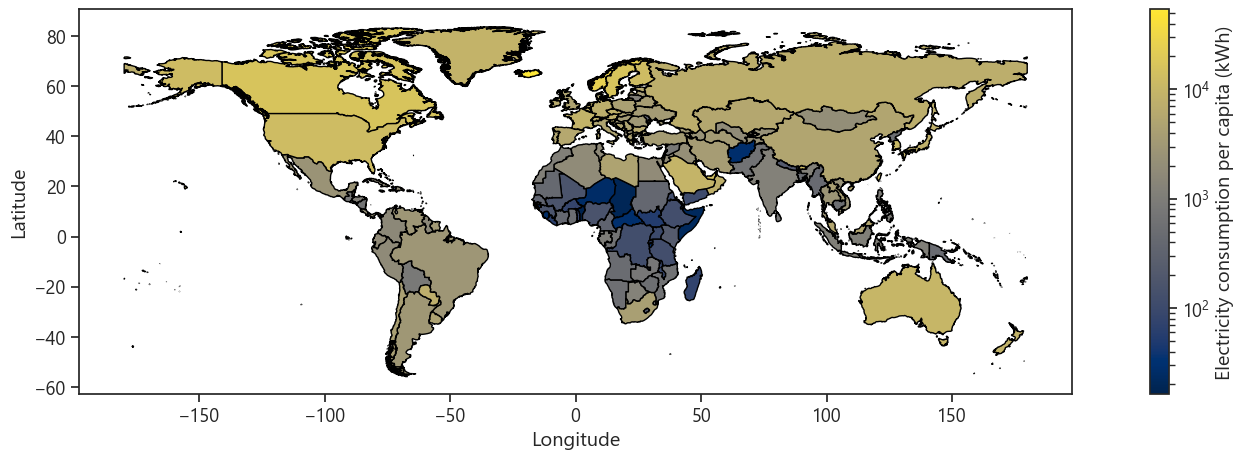

In [92]:
to_plot = countries.query('Year==2019').copy()
minval = to_plot.query('per_capita_electricity>0')['per_capita_electricity'].min()
maxval = to_plot.query('per_capita_electricity>0')['per_capita_electricity'].max()
cmap = cm.cividis
ax = to_plot.plot(
    figsize=(20, 5),
    column='per_capita_electricity',
    legend=True,
    legend_kwds={"label":"Electricity consumption per capita (kWh)"},
    norm=LogNorm(vmin=minval, vmax=maxval),
    cmap=cmap,
    edgecolor='black',
    missing_kwds={'color': 'lightgrey'},
    )
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect(1)
plt.savefig('electricity_consumption_by_country_2019.png', dpi=300, bbox_inches='tight')

Are there any correlations between per capita electricity use (or use of fossil fuels) and death rate?

In [93]:
to_plot = countries[
    [
        'Deaths - Cause: All causes - Risk: Outdoor air pollution - OWID - Sex: Both - Age: All Ages (Number)',
        'Year',
        'coal_elec_per_capita',
        'solar_elec_per_capita',
        'renewables_share_elec',
        'fossil_share_elec',
        'population',
        'gdp',
        'NAME'
    ]
].copy()
to_plot['fossil_share_elec'] /= 100
to_plot['renewables_share_elec'] /= 100
coal_elec_per_capita = 'Electricity from coal per capita (kWh)'
solar_elec_per_capita = 'Electricity from solar per capita (kWh)'
renewables_share_elec = 'Fraction of electricity generation from renewable energy sources (kWh)'
fossil_share_elec = 'Fraction of electricity generation from fossil fuels (kWh)'
od_air_poll_deaths = 'Outdoor air pollution deaths per capita'
gdp_per_cap = 'GDP per capita (USD)'
to_plot.rename(columns=\
    {
        'Deaths - Cause: All causes - Risk: Outdoor air pollution - OWID - Sex: Both - Age: All Ages (Number)':'Outdoor air pollution deaths',
        'coal_elec_per_capita':coal_elec_per_capita,
        'solar_elec_per_capita':solar_elec_per_capita,
        'renewables_share_elec':renewables_share_elec,
        'fossil_share_elec':fossil_share_elec,
    },
    inplace=True)
to_plot[od_air_poll_deaths] = to_plot['Outdoor air pollution deaths']/to_plot['population']
to_plot[gdp_per_cap] = to_plot['gdp']/to_plot['population']

In [94]:
populous_country_names = to_plot.groupby(by='NAME').last().sort_values('population', ascending=False).iloc[:6].index
rich_country_names = to_plot[to_plot['population']>10000000].groupby(by='NAME').last().sort_values(gdp_per_cap, ascending=False).query('NAME!="Saudi Arabia"').iloc[:6].index

In [101]:
populous_countries = to_plot[to_plot['NAME'].isin(populous_country_names)].sort_values('population', ascending=False)
rich_countries = to_plot[to_plot['NAME'].isin(rich_country_names)].sort_values(gdp_per_cap, ascending=False)

In [96]:
palettes = ['Blues', 'Greens', 'Greys', 'Oranges', 'Purples', 'Reds']

In [249]:
def make_new_tick_labels(major_ticks, minor_ticks, orig_lim):
    n_major_ticks = np.sum([True if bisect_left(orig_lim, tick)==1 else False for tick in major_ticks])
    if n_major_ticks==0:
        which_minor_ticks = [2, 3, 4, 5, 6, 7, 8, 9]
    elif n_major_ticks<2:
        which_minor_ticks = [2, 3, 6]
    elif n_major_ticks==2:
        which_minor_ticks = [3]
    else:
        which_minor_ticks = []
    tick_labels = []
    for tick in minor_ticks:
        sign, digits, exponent = Decimal(tick).as_tuple()
        if sign==0:
            sign = ''
        elif sign==1:
            sign = '-'
        if len(digits)==1 or digits[1]==0:
            mantissa = digits[0]
        elif digits[1]==9:
            mantissa = digits[0] + 1
        exponent += len(digits)-1
        label = f'{sign}{mantissa}$\\times 10^'+'{'+str(exponent)+'}$'
        if mantissa in which_minor_ticks:
            tick_labels.append(label)
        else:
            tick_labels.append("")
    return tick_labels

In [295]:
def make_scatterplot(ax, data, x, y, country_names, palettes, xscale, yscale):
    for i in range(len(country_names)):
        country = country_names[i]
        ax = sns.scatterplot(ax=ax,
                            data=data[data['NAME']==country],
                            x=x,
                            y=y,
                            hue="Year",
                            palette=palettes[i],
                            legend=False,
                            label=country)
        n_points_x = len(data[data['NAME']==country][x])
        n_points_y = len(data[data['NAME']==country][y])
        ax.scatter(
            x=[data[data['NAME']==country][x].iloc[int(n_points_x/2)]],
            y=[data[data['NAME']==country][y].iloc[int(n_points_y/2)]],
            c=[sns.color_palette(palettes[i], as_cmap=True)(0.5)],
            label=country)
    ax.set(xscale=xscale, yscale=yscale)
    if xscale=='log':
        orig_xlim = ax.get_xlim()
        new_xtick_labels = make_new_tick_labels(ax.get_xticks(), ax.get_xticks(minor=True), orig_xlim)
        ax.set_xticks(ax.get_xticks(minor=True), labels=new_xtick_labels, minor=True, size='small')
        ax.set_xlim(orig_xlim)
    if yscale=='log':
        orig_ylim = ax.get_ylim()
        new_ytick_labels = make_new_tick_labels(ax.get_yticks(), ax.get_yticks(minor=True), orig_ylim)
        ax.set_yticks(ax.get_yticks(minor=True), labels=new_ytick_labels, minor=True, size='small')
        ax.set_ylim(orig_ylim)

In [301]:
def make_scatterplots(x, y, palettes, xscale, yscale, filename):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    make_scatterplot(axes[0], populous_countries, x, y, populous_country_names, palettes, xscale, yscale)
    make_scatterplot(axes[1], rich_countries, x, y, rich_country_names, palettes, xscale, yscale)
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(
        handles=handles[1::2],
        labels=labels[1::2],
        # loc='center left',
        # bbox_to_anchor=(1, 0.5)
    )
    axes[0].set_title('Most populous countries')
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(
        handles=handles[1::2],
        labels=labels[1::2],
        # loc='center left',
        # bbox_to_anchor=(1, 0.5)
    )
    axes[1].set_title('Richest countries')
    plt.savefig(filename, dpi=300, bbox_inches='tight')

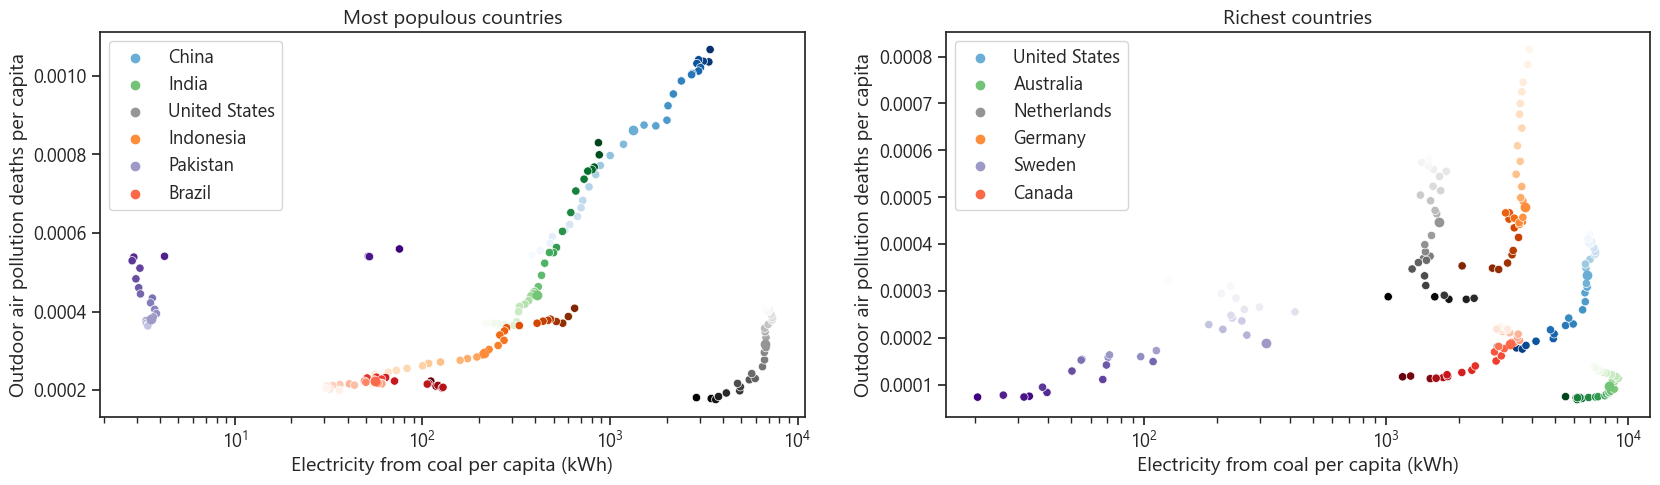

In [302]:
make_scatterplots(
    coal_elec_per_capita,
    od_air_poll_deaths,
    palettes,
    'log',
    'linear',
    'air_poll_deaths_vs_coal_cons.png')

plt.show()

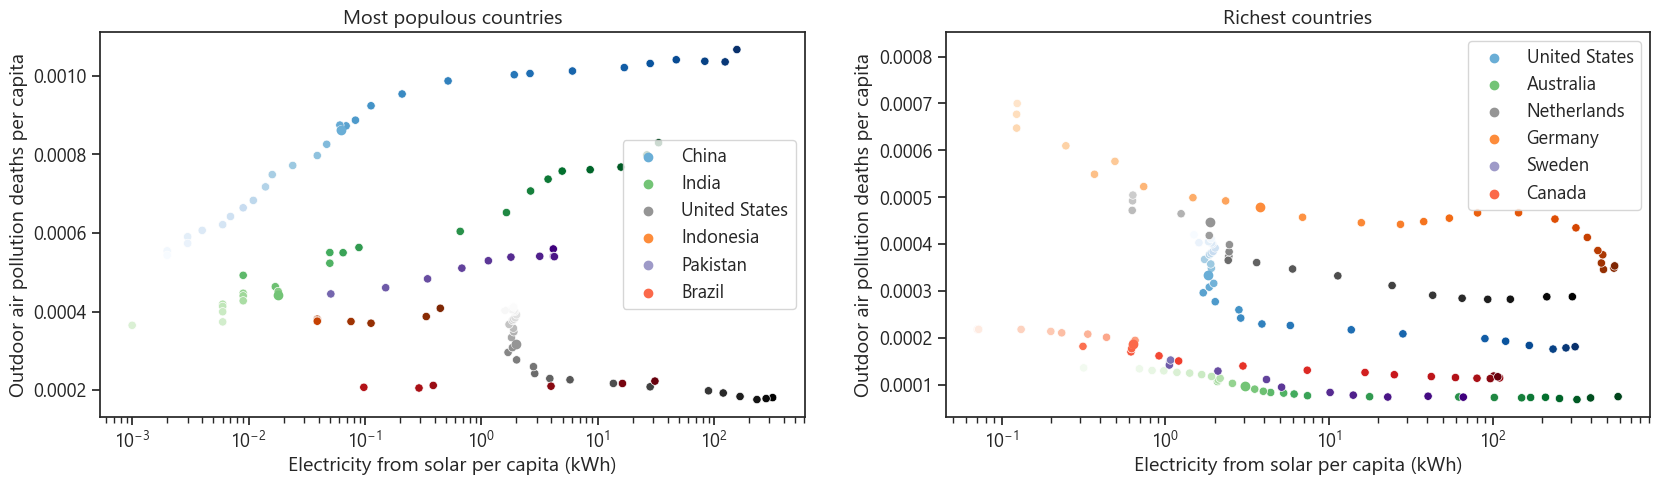

In [303]:
make_scatterplots(
    solar_elec_per_capita,
    od_air_poll_deaths,
    palettes,
    'log',
    'linear',
    'air_poll_deaths_vs_solar_cons.png')

plt.show()

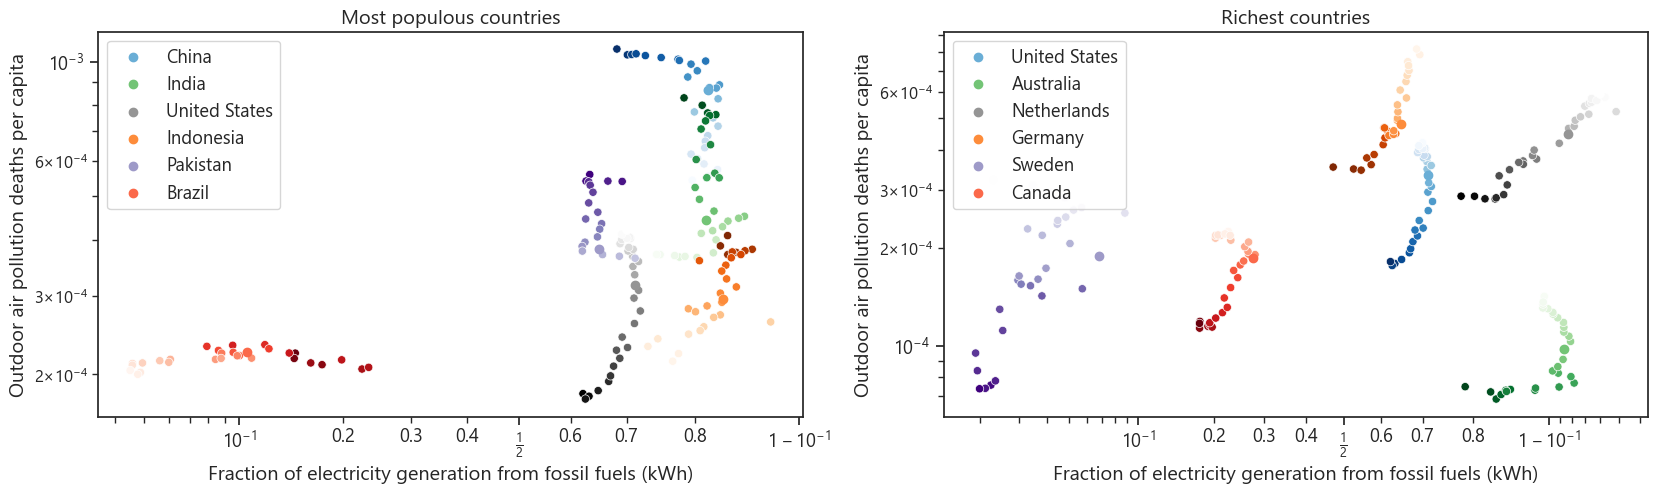

In [304]:
make_scatterplots(
    fossil_share_elec,
    od_air_poll_deaths,
    palettes,
    'logit',
    'log',
    'air_poll_deaths_vs_fossil_share.png')

plt.show()

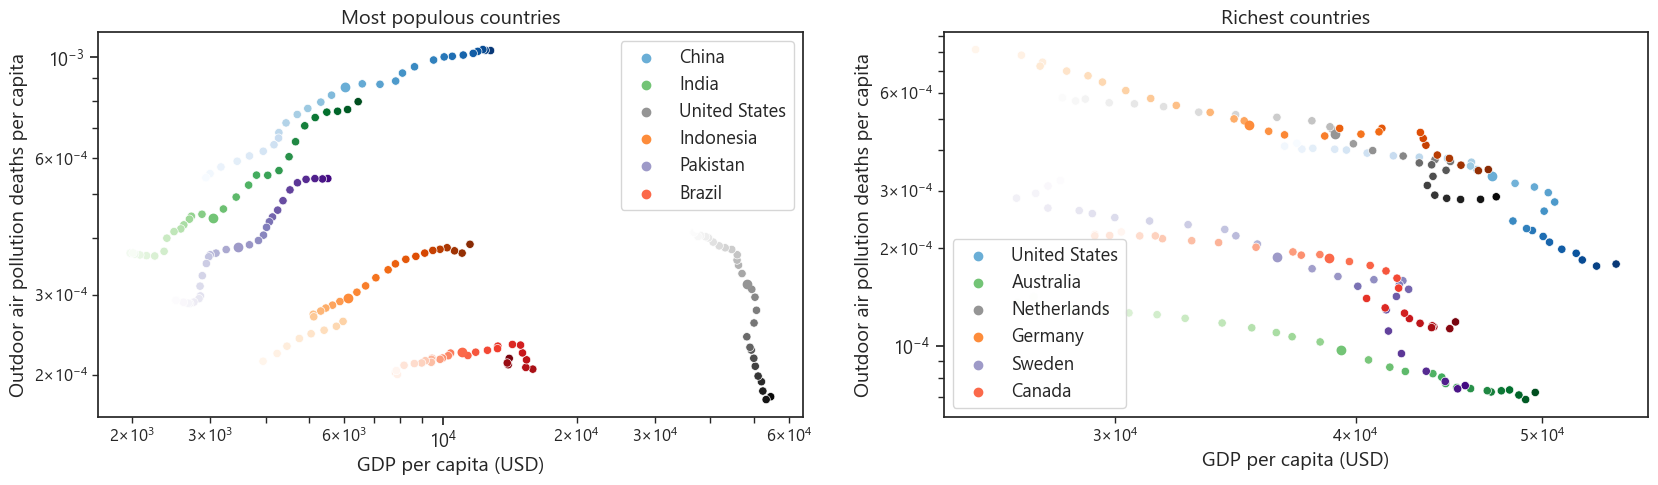

In [305]:
make_scatterplots(
    gdp_per_cap,
    od_air_poll_deaths,
    palettes,
    'log',
    'log',
    'air_poll_deaths_vs_gdp.png')

plt.show()

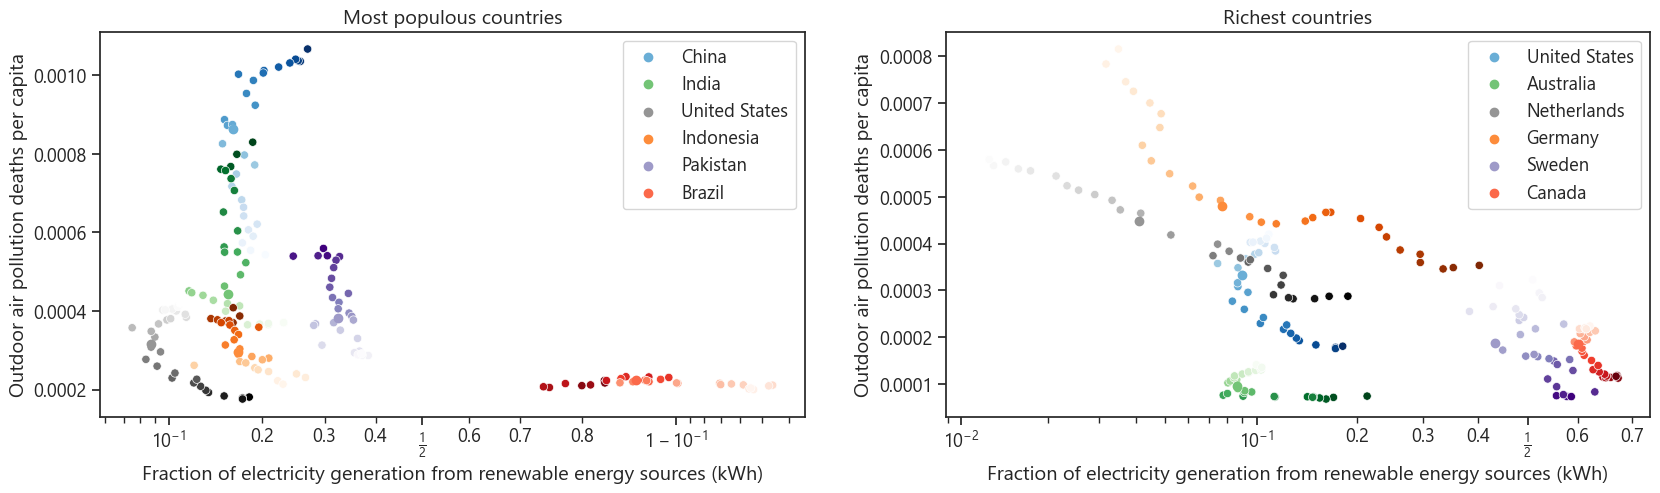

In [306]:
make_scatterplots(
    renewables_share_elec,
    od_air_poll_deaths,
    palettes,
    'logit',
    'linear',
    'air_poll_deaths_vs_renewables_share.png')

plt.show()

In [257]:
all_countries = to_plot['NAME'].unique()

In [258]:
fossil_death_df = to_plot.copy()
fossil_death_df = fossil_death_df[(~np.isinf(fossil_death_df[fossil_share_elec]))&(~fossil_death_df[fossil_share_elec].isna())]

In [259]:
fossil_death_df = to_plot.copy()
fossil_death_df = fossil_death_df[(~np.isinf(fossil_death_df[fossil_share_elec]))&(~fossil_death_df[fossil_share_elec].isna())]
fossil_death_slope = {'NAME':[], 'slope':[]}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for country in all_countries:
        X = sm.add_constant(scipy.special.logit(fossil_death_df[fossil_death_df['NAME']==country][fossil_share_elec]))
        try:
            model = sm.OLS(fossil_death_df[fossil_death_df['NAME']==country][od_air_poll_deaths], X)
        except (MissingDataError, ValueError):
            fossil_death_slope['NAME'].append(country)
            fossil_death_slope['slope'].append(np.nan)
            continue
        try:
            res = model.fit()
        except np.linalg.LinAlgError:
            fossil_death_slope['NAME'].append(country)
            fossil_death_slope['slope'].append(np.nan)
            continue
        if res.params[1]!=0 and res.pvalues[1]<0.05:
            fossil_death_slope['NAME'].append(country)
            fossil_death_slope['slope'].append(res.params[1])
        else:
            fossil_death_slope['NAME'].append(country)
            fossil_death_slope['slope'].append(np.nan)

In [260]:
fossil_death_slope = pd.DataFrame(fossil_death_slope)

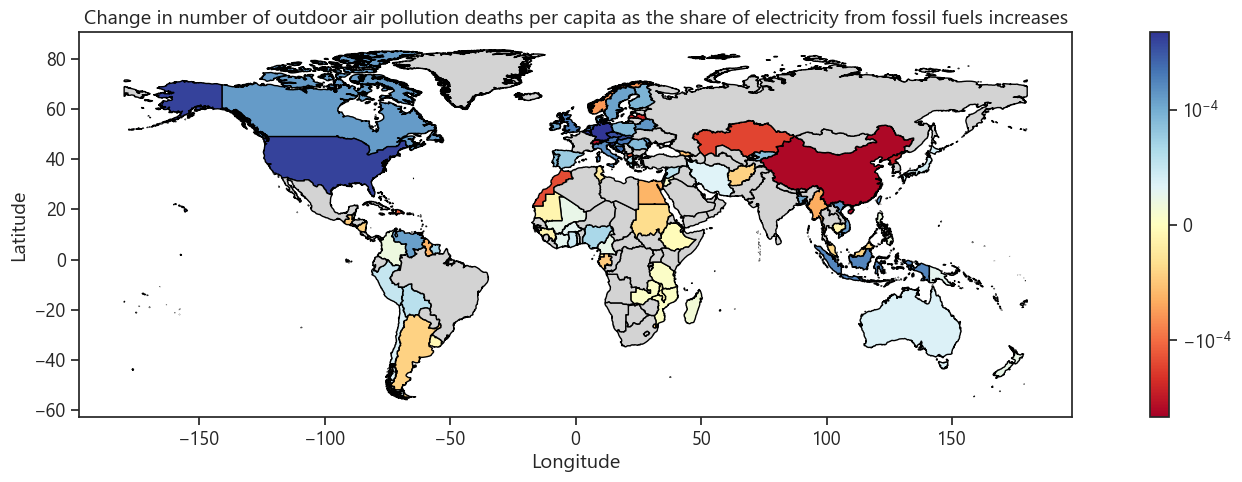

In [261]:
to_plot2 = countries[countries['Year']==2018]
to_plot2 = pd.merge(to_plot2, pd.DataFrame(fossil_death_slope), on='NAME')
cmap = cm.RdYlBu
maxval = abs(to_plot2['slope']).max()
ax = to_plot2.plot(
    figsize=(20, 5),
    column='slope',
    legend=True,
    cmap=cmap,
    missing_kwds={'color': 'lightgrey'},
    norm=SymLogNorm(1e-4, vmin=-maxval, vmax=maxval),
    edgecolor='black',
    )
ax.set_title('Change in number of outdoor air pollution deaths per capita as the share of electricity from fossil fuels increases')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect(1)
plt.savefig('air_poll_deaths_slope_fossil_share.png', dpi=300, bbox_inches='tight')
plt.show()

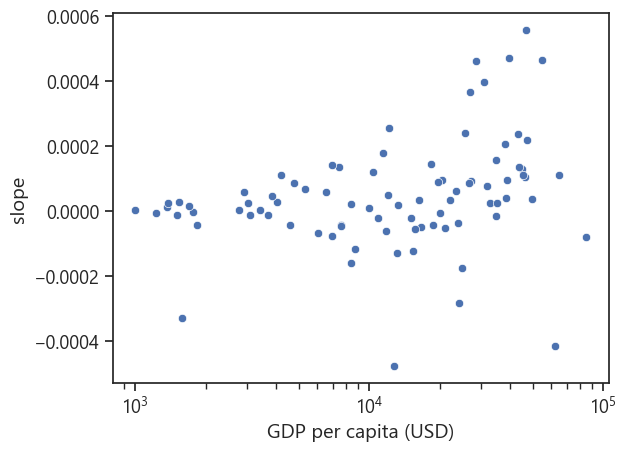

In [262]:
to_plot2[gdp_per_cap] = to_plot2['gdp']/to_plot2['population']
t1 = to_plot2.dropna(subset=[gdp_per_cap, 'slope'])
ax = sns.scatterplot(data=t1, x=gdp_per_cap, y='slope')
ax.set(xscale="log")
plt.savefig('fossil_death_slope_vs_gdp.png', dpi=300, bbox_inches='tight')
plt.show()

In [263]:
coal_death_df = fossil_death_df.copy()
coal_death_slope = {'NAME':[], 'slope':[]}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for country in all_countries:
        X = sm.add_constant(np.log(coal_death_df[coal_death_df['NAME']==country][coal_elec_per_capita]))
        try:
            model = sm.OLS(np.log(coal_death_df[coal_death_df['NAME']==country][od_air_poll_deaths]), X)
        except (MissingDataError, ValueError):
            coal_death_slope['NAME'].append(country)
            coal_death_slope['slope'].append(np.nan)
            continue
        try:
            res = model.fit()
        except np.linalg.LinAlgError:
            coal_death_slope['NAME'].append(country)
            coal_death_slope['slope'].append(np.nan)
            continue
        if res.pvalues[1]<0.05 and res.params[1]!=0:
            coal_death_slope['NAME'].append(country)
            coal_death_slope['slope'].append(res.params[1])
        else:
            coal_death_slope['NAME'].append(country)
            coal_death_slope['slope'].append(np.nan)

In [264]:
coal_death_slope = pd.DataFrame(coal_death_slope)

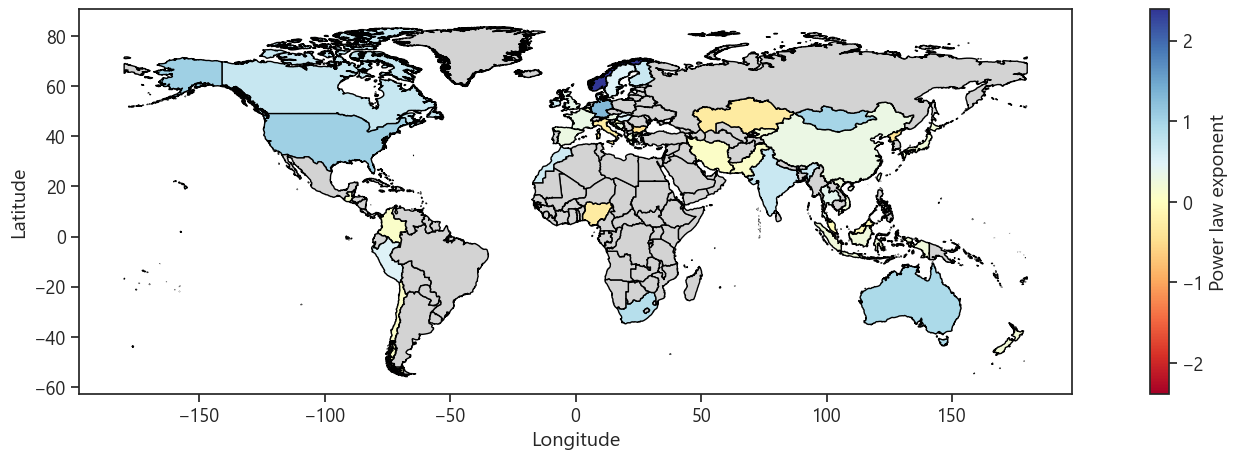

In [265]:
to_plot = countries[countries['Year']==2018]
to_plot = pd.merge(to_plot, coal_death_slope, on='NAME')
cmap = cm.RdYlBu
maxval = abs(to_plot['slope']).max()
ax = to_plot.plot(
    figsize=(20, 5),
    column='slope',
    legend=True,
    cmap=cmap,
    missing_kwds={'color': 'lightgrey'},
    legend_kwds={"label":"Power law exponent"},
    # norm=SymLogNorm(1e0, vmin=-maxval, vmax=maxval),
    vmin=-maxval,
    vmax=maxval,
    edgecolor='black',
    )
# ax.set_title('Change in number of deaths from outdoor air pollution per TWh increase in electricity from coal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect(1)
plt.savefig('air_poll_deaths_slope_coal_cons.png', dpi=300, bbox_inches='tight')
plt.show()